# **Projet Maths Info**

**Objectif:** affichage de lignes de niveau d'une fonction f.

Nous commençons par l'importation des différentes bibliothèques nécessaires à la réalisation du projet:
- autograd pour le calcul différentiel;
- numpy pour l'utilisation de fonctions comme exp, racine ...
- matplotlib.pyplot pour l'affichage 5.

In [3]:
import autograd
import numpy as np
from autograd import numpy as np
import matplotlib.pyplot as plt

## **Amorce**

Le but est ici de réaliser la fonction *find_seed*, qui permet de résoudre l'équation *g(0,t) = c (E)* d'inconnue *t*, dans les cas où cela est possible.

Elle prend en entrée la fonction *g*, le réel *c* dont la valeur par défaut est posée à *0*, le réel *eps* (tolérance sur l'écart entre *g(0,t_cherché)* et *0*) dont la valeur par défaut est posée à *2**(-26)*.

Pour ce faire, on impose que *c* appartienne à l'intervalle _[g(0,0), g(0,1)]_ (ou _[g(0,1), g(0,0)]_ selon les cas), afin que, par Théorème des Valeurs Intermédiaires, appliqué à la fonction *y -> g(0,y)*, l'équation *(E)* admette une solution. 
On utilise ensuite la méthode de Newton. 

On teste à l'aide de la fonction cercle. 

In [24]:
def find_seed(g, c = 0, eps = 2**(-26)):
    """
    renvoie: 
    - le réel t tel que g(0,t)=c
    - None si ce réel t n'existe pas

    """
    if not ((g(0,0) <= c <= g(0,1)) or (g(0,0) >= c >= g(0,1))):
        return None
    def f(x):
        return g(0,x)-c
    deriv_f = autograd.grad(f)

    u = 0.5
    while abs(f(u)) > eps:
        a = deriv_f(u)
        if a != 0:
            u = u-f(u)/a
    return u

def cercle (x,y):
    return (x**2 + y**2)

print (find_seed(cercle, -0.1))
print (find_seed(cercle, 0.5**2))

None
0.5


## **Propagation**
**Réalisation de simple_contour.**

Intuitivement, on implémente une méthode constituant à suivre la tangente, et négliger l'erreur d'ordre 1 à chaque itération. 
Nous verrons que cette méthode apporte des résultats relativement cohérents, même si les erreurs s'ajoutent à chaque itération. 

On teste cette fonction *simple_contour_intuitive* à l'aide de la fonction précédente. 

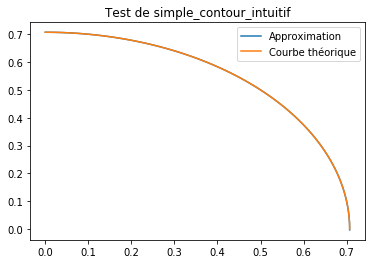

In [17]:
def simple_contour_intuitif(f,c=0.0,delta=0.01,eps=2**(-26)):
    """
    Méthode utilisée: suivre la tangente
    Une erreur d'ordre 1 est commise à chaque itération
    """
    # initialisation
    x_0, y_0 = 0.0, find_seed(f,c,eps)
    if y_0 == None:
        return (np.array([]), np.array([]))

    x_approx, y_approx = [x_0], [y_0]

    def gradient(f):
        def grad_f(x,y):
            g = autograd.grad
            return np.r_[g(f, 0)(x,y), g(f, 1)(x,y)]
        return grad_f

    grad = gradient(f)
    L = grad(x_0,y_0)
    a, b = L[0], L[1]

    n_0 = [-b, a] # tangente orthogonale au gradient


    n_0[0] = n_0[0]*delta/(np.sqrt(b**2+a**2)) # on norme n_0 à delta
    n_0[1] = n_0[1]*delta/(np.sqrt(b**2+a**2))

    x_test, y_test = x_0 + n_0[0], y_0 + n_0[1]


    if not(0 <= x_test <= 1 and 0 <= y_test <= 1):
        n_0 = [-n_0[0],-n_0[1]] # on change de sens

    x_0, y_0 = x_0 + n_0[0], y_0 + n_0[1]
    x_approx.append (x_0)
    y_approx.append (y_0)


    while 0 <= x_0 <= 1 and 0 <= y_0 <= 1:

        # obtention de la valeur approchée
        L = grad(x_0,y_0)
        a,b = L[0], L[1]
        n = [-b, a]

        if (n[0]*n_0[0] + n[1]*n_0[1])<0 : # (n_0, n)<0
            n = [-n[0], -n[1]]

        n[0] = n[0]*delta/(np.sqrt(b**2+a**2))
        n[1] = n[1]*delta/(np.sqrt(b**2+a**2))

        x_1, y_1 = x_0 + n[0], y_0 + n[1]
        x_2, y_2 = x_1, y_1


        x_approx.append (x_1)
        y_approx.append (y_1)

        # rang suivant
        x_0, y_0 = x_2, y_2
        n_0 = n

    return (np.array(x_approx), np.array(y_approx))

def test(f,c) :
    plt.figure()
    plt.title("Test de simple_contour_intuitif")
    x_approx, y_approx = simple_contour (f, c)
    plt.plot (x_approx, y_approx, label="Approximation")
    plt.plot([0.5**0.5*np.cos(x) for x in (np.linspace(0,np.pi/2,101))], [0.5**0.5*np.sin(x) for x in (np.linspace(0,np.pi/2,101))], label="Courbe théorique")
    plt.legend()
    plt.show()

test(cercle, 0.5)

On observe donc une légère différence avec la courbe théorique. 
Pour s'affranchir de cette différence, on recalcule à chaque itération le point théorique. L'idée est de partir du point approximé, de suivre le gradient dans le bon sens (on utilise la propriété du gradient selon laquelle il pointe toujours dans le sens des potentiels croissants) et de chercher la solution réelle dans ce sens. Le code obtenu est pour la plus grande partie analogue au code précédent. 

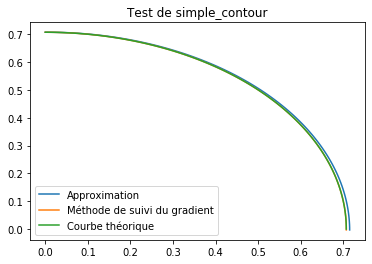

In [18]:
def simple_contour(f,c=0.0,delta=0.01,eps=2**(-26)):
    """
    Méthode utilisée: suivre le gradient dans le bon sens pour se rapprocher au plus vite de la vraie solution, après avoir initialisé avec la valeur approchée
    ---------------------------------
    renvoie
    - un fragment de ligne de niveau sous la forme de deux tableaux 1d de points de cette ligne
    - deux tableaux vides si cette ligne de niveau n'existe pas
    """
    # initialisation
    x_0, y_0 = 0.0, find_seed(f,c,eps)
    if y_0==None:
        return (np.array([]), np.array([]))

    x_approx, y_approx = [x_0], [y_0]
    x, y = [x_0], [y_0]

    def gradient(f):
        def grad_f(x,y):
            g = autograd.grad
            return np.r_[g(f, 0)(x,y), g(f, 1)(x,y)]
        return grad_f

    grad = gradient(f)
    L = grad(x_0,y_0)
    a, b = L[0], L[1]

    n_0 = [-b, a] # tangente orthogonale au gradient


    n_0[0] = n_0[0]*delta/(np.sqrt(b**2+a**2)) # on norme n_0 à delta
    n_0[1] = n_0[1]*delta/(np.sqrt(b**2+a**2))

    x_test, y_test = x_0 + n_0[0], y_0 + n_0[1]


    if not(0<=x_test<=1 and 0<=y_test<=1):
        n_0=[-n_0[0],-n_0[1]] # on change de sens

    x_0, y_0 = x_0 + n_0[0], y_0 + n_0[1]
    x_approx.append (x_0)
    y_approx.append (y_0)


    while 0<=x_0<=1 and 0<=y_0<=1:

        # obtention de la valeur approchée
        L = grad(x_0,y_0)
        a,b = L[0], L[1]
        n = [-b, a]

        if (n[0]*n_0[0] + n[1]*n_0[1])<0 : # (n_0, n)<0
            n = [-n[0], -n[1]]

        n[0] = n[0]*delta/(np.sqrt(b**2+a**2))
        n[1] = n[1]*delta/(np.sqrt(b**2+a**2))

        x_1, y_1 = x_0 + n[0], y_0 + n[1]
        x_2, y_2 = x_1, y_1
        u = np.array([x_2,y_2])
        # le gradient étant orienté dans le sens des potentiels croissants
        # il suffit de suivre le gradient dans le bon sens
        while abs (f(u[0],u[1])-c) > eps:
            gradient = grad(u[0],u[1])
            if f(u[0],u[1])>c:
                u = u - abs(f(u[0],u[1])-c)*gradient/(np.vdot(gradient,gradient))
            elif f(u[0],u[1])<c:
                u = u + abs(f(u[0],u[1])-c)*gradient/(np.vdot(gradient,gradient))


        x_approx.append (x_1)
        y_approx.append (y_1)

        x.append (u[0])
        y.append (u[1])

        # rang suivant
        x_0, y_0 = x_2, y_2
        n_0 = n

    return (np.array(x), np.array(y))

def test(f,c) :
    plt.figure()
    plt.title("Test de simple_contour")
    x_approx, y_approx = simple_contour_intuitif (f, c)
    x_th, y_th = simple_contour (f, c)
    plt.plot (x_approx, y_approx, label="Approximation")
    plt.plot (x_th, y_th, label="Méthode de suivi du gradient")
    plt.plot([0.5**0.5*np.cos(x) for x in (np.linspace(0,np.pi/2,101))], [0.5**0.5*np.sin(x) for x in (np.linspace(0,np.pi/2,101))], label="Courbe théorique")
    plt.legend()
    plt.show()

test(cercle, 0.5)

La nouvelle courbe apparaît confondue à la courbe théorique. 

Pour la suite, on utilise le code donné sur le discourse. 

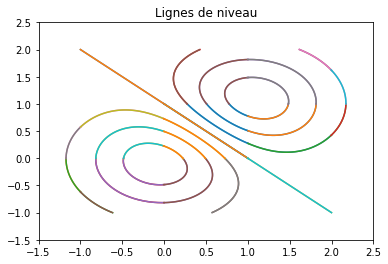

In [27]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

# Test 
def f(x,y):
    return x**2 + y**2

def h(x,y):
    return np.exp(-x**2 - y**2)

def g(x,y):
    return np.exp(-(x-1)**2 - (y-1)**2)

def fonction(x,y):
    """
    pour tester contour_complexe
    """
    return 2*(h(x,y) - g(x,y))

niveaux = [-1.5,-1.,-0.5,0.,0.5,1.,1.5]
fig, ax = plt.subplots()
plt.title("Lignes de niveau")

for i in niveaux:
    curves = contour(fonction,i,[-2.,-1.,0.,1.,2.,3.],[-1.,0.,1.,2.])
    for x,y in curves:
        ax.plot(x,y)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2.5)
plt.show()